In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -al drive/MyDrive/'Colab Notebooks'/dnn_examples/part2-/dataset/

ls: cannot access 'drive/MyDrive/Colab Notebooks/dnn_examples/part2-/dataset/': No such file or directory


In [22]:
# 데이터를 np array로 training에서 사람 이미지 한장을 불러오는 코드를 작성해주세요. (x로 변수 대입)
import imageio
x = imageio.imread('/content/drive/My Drive/Colab Notebooks/000002.jpg')

In [23]:
x.shape

(218, 178, 3)

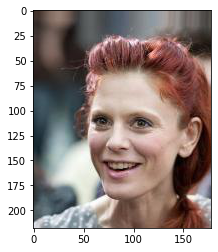

In [24]:
plt.imshow(x)
plt.show()

In [25]:
from skimage.transform import resize
x1 = resize(x,(100,75))


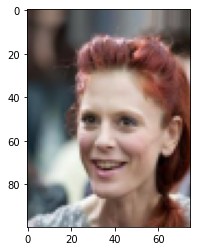

In [26]:
plt.imshow(x1)
plt.show()

In [27]:
!gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

Downloading...
From: https://drive.google.com/uc?id=1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl
To: /content/pfcn_small.npz
100% 137M/137M [00:01<00:00, 116MB/s] 


In [28]:
pfcn_small = np.load('/content/pfcn_small.npz')

In [29]:
train_images = pfcn_small['train_images']

In [30]:
test_images = pfcn_small['test_images']

In [31]:
train_images[train_images != 0][:10]

array([0.23627451, 0.34803922, 0.64705882, 0.24509804, 0.35686275,
       0.65588235, 0.25490196, 0.36470588, 0.66470588, 0.2372549 ])

In [32]:
print(train_images.dtype)
print(x.dtype)

float64
uint8


In [33]:
print(train_images.shape, train_images.dtype)

(1700, 100, 75, 3) float64


In [34]:
print(test_images.shape, test_images.dtype)

(300, 100, 75, 3) float64


In [35]:
print(train_images.min(), train_images.max())

0.0 1.0


In [36]:
print(test_images.min(), test_images.max())

0.0 1.0


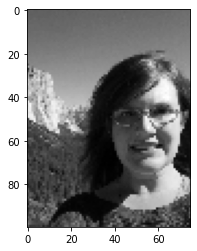

In [38]:
from skimage import color
# 흑백으로 변환
plt.imshow(color.rgb2gray(train_images[0]),cmap = 'gray')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


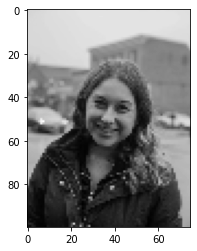

In [41]:
train_gray_images = color.rgb2gray(train_images)
test_gray_images = color.rgb2gray(test_images)
plt.imshow(color.rgb2gray(train_gray_images[5]), cmap='gray')
plt.show()

In [42]:
train_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1))for img in train_images])

In [43]:
test_gray_images = np.array([color.rgb2gray(img).reshape((100,75,1)) for img in test_images])

In [44]:
train_gray_images.shape, test_gray_images.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

In [46]:
train_images[:5].shape

(5, 100, 75, 3)

In [50]:
train_images[:5].transpose((1,0,2,3)).reshape(100,-1,1).shape

(100, 1125, 1)

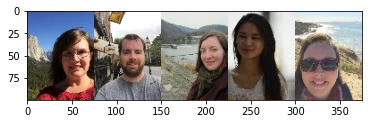

In [52]:
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape(100,-1,3))
plt.show()

In [54]:
# 칼라-> 흑백 모델링

from keras.layers import Conv2D, Dense, Input, Conv2DTranspose, Flatten, Reshape
from keras.layers import MaxPool2D, Dropout, BatchNormalization, Activation, concatenate
from keras.models import Model

In [55]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def U_Net():
    inputs = Input((100, 75, 3))
    # 원 논문에선 64 - 128 - 256- 512 - 1024
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding='valid', output_padding=((0,1)))(c5)
    c6 = concatenate([u6, c4])
    c6 = Dropout(0.1)(c6)
    c6 = conv2d_block(c6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=((1,0)))(c6)
    c7 = concatenate([u7, c3])
    c7 = Dropout(0.1)(c7)
    c7 = conv2d_block(c7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=((0,1)))(c7)
    c8 = concatenate([u8, c2])
    c8 = Dropout(0.1)(c8)
    c8 = conv2d_block(c8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=((0,1)))(c8)
    c9 = concatenate([u9, c1])
    c9 = Dropout(0.1)(c9)
    c9 = conv2d_block(c9, 16)

    outputs = Conv2D(1,1, activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

In [56]:
# 모델을 할당받고 서머리 출력
model = U_Net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 75, 16)  448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 75, 16)  64         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [57]:
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['acc'])

In [58]:
hist = model.fit(
    train_images,
    train_gray_images,
    validation_data = (test_images, test_gray_images),
    epochs = 10,
    verbose =1
)

Epoch 1/10
54/54 [==============================] - 229s 4s/step - loss: 0.0707 - acc: 0.0111 - val_loss: 0.1845 - val_acc: 0.0181
Epoch 2/10
54/54 [==============================] - 164s 3s/step - loss: 0.0403 - acc: 0.0116 - val_loss: 0.1618 - val_acc: 0.0181
Epoch 3/10
54/54 [==============================] - 165s 3s/step - loss: 0.0354 - acc: 0.0116 - val_loss: 0.1413 - val_acc: 0.0181
Epoch 4/10
54/54 [==============================] - 163s 3s/step - loss: 0.0323 - acc: 0.0116 - val_loss: 0.1106 - val_acc: 0.0181
Epoch 5/10
54/54 [==============================] - 165s 3s/step - loss: 0.0284 - acc: 0.0116 - val_loss: 0.0827 - val_acc: 0.0181
Epoch 6/10
54/54 [==============================] - 162s 3s/step - loss: 0.0283 - acc: 0.0116 - val_loss: 0.0601 - val_acc: 0.0181
Epoch 7/10
54/54 [==============================] - 163s 3s/step - loss: 0.0292 - acc: 0.0116 - val_loss: 0.0425 - val_acc: 0.0181
Epoch 8/10
54/54 [==============================] - 162s 3s/step - loss: 0.0254 - a

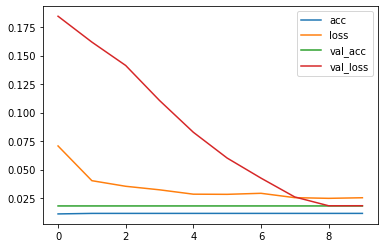

In [59]:
plt.plot(hist.history['acc'],label = 'acc')
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_acc'],label = 'val_acc')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = "upper right")
plt.show()

In [60]:
res = model.predict(test_images[1:2])

In [61]:
res.shape

(1, 100, 75, 1)

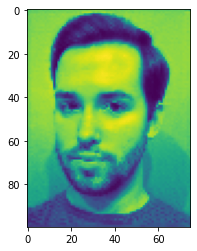

In [65]:
plt.imshow(res.reshape(100,-1))

In [66]:
imgs = np.concatenate([res[0],test_gray_images[1]],axis = 1).reshape((100,-1))

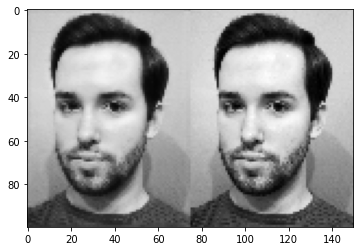

In [67]:
plt.imshow(imgs,cmap = 'gray')

In [68]:
loss, acc = model.evaluate(test_images, test_gray_images, verbose = 2)

10/10 - 10s - loss: 0.0183 - acc: 0.0181 - 10s/epoch - 975ms/step


In [70]:
loss,acc

(0.01830925978720188, 0.018117332831025124)